# Question-Answering Machine Learning Model (DistilBERT)



## Download SQuADv2.0 Dataset

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json dev-v2.0.json

--2022-06-25 12:30:21--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2022-06-25 12:30:24 (369 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2022-06-25 12:30:24--  http://train-v2.0.json/
Resolving train-v2.0.json (train-v2.0.json)... failed: Name or service not known.
wget: unable to resolve host address ‘train-v2.0.json’
FINISHED --2022-06-25 12:30:24--
Total wall clock time: 2.9s
Downloaded: 1 files, 40M in 0.1s (369 MB/s)
--2022-06-25 12:30:24--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install wget
!pip install transformers==3.5
!pip install tensorflow==2.3.1
!pip install torch==1.6
!pip install -Uqq ipdb
import ipdb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse
import glob
import logging
import os
import random
import timeit
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    squad_convert_examples_to_features,
)
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor
from torch.utils.data import TensorDataset

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [ ]:
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

## DATASET FRACTION

In [ ]:
coef = 0.2

import json

# Opening JSON file
f = open('./dev-v1.1.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

length = len(data['data'])

newlen = int(length * coef)

data_frag = random.sample(data['data'], newlen)

newdata = {"data": data_frag}

with open('./dev-v2.0.json', 'w', encoding='utf-8') as f1:
    json.dump(newdata, f1, ensure_ascii=False, indent=4)

f.close()

## MODEL_FOR_QUESTION_ANSWERING_MAPPING

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")

        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 1
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    # Added here for reproductibility
    set_seed(args)

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)

            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "start_positions": batch[3],
                "end_positions": batch[4],
            }

            if args.model_type in ["xlm", "roberta", "distilbert", "camembert", "bart"]:
                del inputs["token_type_ids"]


            outputs = model(**inputs)
            # model outputs are always tuple in transformers (see doc)
            loss = outputs[0]

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel (not distributed) training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            tr_loss += loss.item()

            if (step + 1) % args.gradient_accumulation_steps == 0:

                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                # Log metrics
                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Only evaluate when single GPU otherwise metrics may not average well
                    if args.local_rank == -1 and args.evaluate_during_training:
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step


## eval

In [ ]:
def evaluate(args, model, tokenizer, train_dataset):
    dataset, examples, features = load_and_cache_examples(args, tokenizer, evaluate=True, output_examples=True)

    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)

    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # multi-gpu evaluate
    if args.n_gpu > 1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)

    all_results = []
    start_time = timeit.default_timer()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            if args.model_type in ["xlm", "roberta", "distilbert", "camembert", "bart"]:
                del inputs["token_type_ids"]

            feature_indices = batch[3]

            # XLNet and XLM use more arguments for their predictions
            if args.model_type in ["xlnet", "xlm"]:
                inputs.update({"cls_index": batch[4], "p_mask": batch[5]})
                # for lang_id-sensitive xlm models
                if hasattr(model, "config") and hasattr(model.config, "lang2id"):
                    inputs.update(
                        {"langs": (torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id).to(args.device)}
                    )
                    
            outputs = model(**inputs)

        for i, feature_index in enumerate(feature_indices):
            eval_feature = features[feature_index.item()]
            unique_id = int(eval_feature.unique_id)

            output = [to_list(output[i]) for output in outputs]

            # Some models (XLNet, XLM) use 5 arguments for their predictions, while the other "simpler"
            # models only use two.
            if len(output) >= 5:
                start_logits = output[0]
                start_top_index = output[1]
                end_logits = output[2]
                end_top_index = output[3]
                cls_logits = output[4]

                result = SquadResult(
                    unique_id,
                    start_logits,
                    end_logits,
                    start_top_index=start_top_index,
                    end_top_index=end_top_index,
                    cls_logits=cls_logits,
                )

            else:
                start_logits, end_logits = output
                result = SquadResult(unique_id, start_logits, end_logits)

            all_results.append(result)

    evalTime = timeit.default_timer() - start_time
    logger.info("  Evaluation done in total %f secs (%f sec per example)", evalTime, evalTime / len(dataset))

    # Compute predictions
    output_prediction_file = os.path.join(args.output_dir, "predictions_{}.json".format(prefix))
    output_nbest_file = os.path.join(args.output_dir, "nbest_predictions_{}.json".format(prefix))

    if args.version_2_with_negative:
        output_null_log_odds_file = os.path.join(args.output_dir, "null_odds_{}.json".format(prefix))
    else:
        output_null_log_odds_file = None

    # XLNet and XLM use a more complex post-processing procedure
    if args.model_type in ["xlnet", "xlm"]:
        start_n_top = model.config.start_n_top if hasattr(model, "config") else model.module.config.start_n_top
        end_n_top = model.config.end_n_top if hasattr(model, "config") else model.module.config.end_n_top

        predictions = compute_predictions_log_probs(
            examples,
            features,
            all_results,
            args.n_best_size,
            args.max_answer_length,
            output_prediction_file,
            output_nbest_file,
            output_null_log_odds_file,
            start_n_top,
            end_n_top,
            args.version_2_with_negative,
            tokenizer,
            args.verbose_logging,
        )
    else:
        predictions = compute_predictions_logits(
            examples,
            features,
            all_results,
            args.n_best_size,
            args.max_answer_length,
            args.do_lower_case,
            output_prediction_file,
            output_nbest_file,
            output_null_log_odds_file,
            args.verbose_logging,
            args.version_2_with_negative,
            args.null_score_diff_threshold,
            tokenizer,
        )

    # Compute the F1 and exact scores.
    results = squad_evaluate(examples, predictions)
    return results


## Dataload

In [ ]:
def load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=False):
    if args.local_rank not in [-1, 0] and not evaluate:
        # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        torch.distributed.barrier()

    # Load data features from cache or dataset file
    input_dir = args.data_dir if args.data_dir else "."
    cached_features_file = os.path.join(
        input_dir,
        "cached_{}_{}_{}".format(
            "dev" if evaluate else "train",
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_length),
        ),
    )
    root_dir = os.path.join(cached_features_file+"_dir")
    features_file = os.path.join(root_dir,'features')
    datasets_file = os.path.join(root_dir,'datasets')
    examples_file = os.path.join(root_dir,'examples')

    # Init features and dataset from cache if it exists
    if os.path.exists(cached_features_file) and not args.overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features_and_dataset = torch.load(cached_features_file)
        features, dataset, examples = (
            features_and_dataset["features"],
            features_and_dataset["dataset"],
            features_and_dataset["examples"],
        )
        if output_examples:
            return features, dataset, examples
        else:
            return dataset
    elif os.path.exists(datasets_file) and not output_examples and not args.overwrite_cache:
        pass
    elif os.path.exists(datasets_file) and os.path.exists(features_file) and os.path.exists(examples_file) and output_examples and not args.overwrite_cache:
        pass
    else:
        logger.info("Creating features from dataset file at %s", input_dir)

        if not args.data_dir and ((evaluate and not args.predict_file) or (not evaluate and not args.train_file)):
            try:
                import tensorflow_datasets as tfds
            except ImportError:
                raise ImportError("If not data_dir is specified, tensorflow_datasets needs to be installed.")

            if args.version_2_with_negative:
                logger.warn("tensorflow_datasets does not handle version 2 of SQuAD.")

            tfds_examples = tfds.load("squad")
            examples = SquadV1Processor().get_examples_from_dataset(tfds_examples, evaluate=evaluate)
        else:
            processor = SquadV2Processor() if args.version_2_with_negative else SquadV1Processor()
            if evaluate:
                examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file)
            else:
                examples = processor.get_train_examples(args.data_dir, filename=args.train_file)
        
        args.data_process_batch = args.data_process_batch if args.data_process_batch>0 else len(examples)
        for i,j in enumerate(range(0,len(examples),args.data_process_batch)):
            sub_examples = examples[j:j+args.data_process_batch]
            features, dataset = squad_convert_examples_to_features(
                examples=sub_examples,
                tokenizer=tokenizer,
                max_seq_length=args.max_seq_length,
                doc_stride=args.doc_stride,
                max_query_length=args.max_query_length,
                is_training=not evaluate,
                return_dataset="pt",
                threads=args.threads,
            )

            if args.local_rank in [-1, 0]:
                if not os.path.exists(os.path.join(features_file)):
                    os.makedirs(os.path.join(features_file))
                if not os.path.exists(os.path.join(datasets_file)):
                    os.makedirs(os.path.join(datasets_file))
                if not os.path.exists(os.path.join(examples_file)):
                    os.makedirs(os.path.join(examples_file))

                logger.info("Saving features into cached files %s, %s, %s", os.path.join(features_file,'features_'+str(i)),os.path.join(datasets_file,'datasets_'+str(i)),os.path.join(examples_file,'examples_'+str(i)))
                torch.save({"features": features}, os.path.join(features_file,'features_'+str(i)))
                torch.save({"datasets": dataset}, os.path.join(datasets_file,'datasets_'+str(i)))
                torch.save({"examples": sub_examples}, os.path.join(examples_file,'examples_'+str(i)))

    if args.local_rank == 0 and not evaluate:
        # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        torch.distributed.barrier()
    return read_saved_data(root_dir,evaluate=evaluate,output_examples=output_examples)


In [ ]:
def read_saved_data(input_dir,evaluate=False,output_examples=False):
    from torch.utils.data import TensorDataset

    if output_examples:
        feat="features;datasets;examples"
    else:
        feat="datasets"

    all_features = {"features":[],"examples":[],"datasets":[]}
    all_input_ids = torch.tensor([], dtype=torch.long)
    all_attention_masks = torch.tensor([], dtype=torch.long)
    all_token_type_ids = torch.tensor([], dtype=torch.long)
    all_cls_index = torch.tensor([], dtype=torch.long)
    all_p_mask = torch.tensor([], dtype=torch.float)
    all_is_impossible = torch.tensor([], dtype=torch.float)
    all_start_positions = torch.tensor([], dtype=torch.long)
    all_end_positions = torch.tensor([], dtype=torch.long)

    for i in feat.split(";"):
        for file_name in os.listdir(os.path.join(input_dir,i)):
            data = torch.load(os.path.join(input_dir,i,file_name))[i]
            if isinstance(data,TensorDataset):
                if evaluate:
                    all_input_ids = torch.cat([all_input_ids,data.tensors[0]],dim=0)
                    all_attention_masks = torch.cat([all_attention_masks,data.tensors[1]],dim=0)
                    all_token_type_ids = torch.cat([all_token_type_ids,data.tensors[2]],dim=0)
                    all_cls_index = torch.cat([all_cls_index,data.tensors[4]],dim=0)
                    all_p_mask = torch.cat([all_p_mask,data.tensors[5]],dim=0)

                    #all_start_positions = torch.cat([all_start_positions,data.tensors[6]],dim=0)
                    #all_end_positions = torch.cat([all_end_positions,data.tensors[7]],dim=0)
                else:
                    all_input_ids = torch.cat([all_input_ids,data.tensors[0]],dim=0)
                    all_attention_masks = torch.cat([all_attention_masks,data.tensors[1]],dim=0)
                    all_token_type_ids = torch.cat([all_token_type_ids,data.tensors[2]],dim=0)
                    all_start_positions = torch.cat([all_start_positions,data.tensors[3]],dim=0)
                    all_end_positions = torch.cat([all_end_positions,data.tensors[4]],dim=0)
                    all_cls_index = torch.cat([all_cls_index,data.tensors[5]],dim=0)
                    all_p_mask = torch.cat([all_p_mask,data.tensors[6]],dim=0)
                    all_is_impossible = torch.cat([all_is_impossible,data.tensors[7]],dim=0)
            elif isinstance(data,list):
                all_features[i] += data
    
    if evaluate and "datasets" in feat.split(";"):
        all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
        all_features["datasets"] = TensorDataset(all_input_ids, all_attention_masks, all_token_type_ids, all_example_index, all_cls_index, all_p_mask)
    elif not evaluate and "datasets" in feat.split(";"):
        all_features["datasets"] = TensorDataset(all_input_ids,all_attention_masks,all_token_type_ids,all_start_positions,all_end_positions,all_cls_index,all_p_mask,all_is_impossible,)


    if output_examples:
        return all_features['datasets'], all_features['examples'], all_features['features']
    else:
        return all_features['datasets']


## Arguments setup

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--model_type",
    type=str,
    default="distilbert",
    help="Model type selected in the list: " + ", ".join(MODEL_TYPES),
)
parser.add_argument(
    "--model_name_or_path",
    type=str,
    default="distilbert-base-uncased",
    help="Path to pretrained model or model identifier from huggingface.co/models",
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="./distilbert-squad-100",
    help="The output directory where the model checkpoints and predictions will be written.",
)

# Other parameters
parser.add_argument(
    "--data_dir",
    default=None,
    type=str,
    help="The input data dir. Should contain the .json files for the task."
    + "If no data dir or train/predict files are specified, will run with tensorflow_datasets.",
)
parser.add_argument(
    "--train_file",
    type=str,
    default="train-v2.0.json",
    help="The input training file. If a data dir is specified, will look for the file there"
    + "If no data dir or train/predict files are specified, will run with tensorflow_datasets.",
)
parser.add_argument(
    "--predict_file",
    type=str,
    default='dev-v2.0.json',
    help="The input evaluation file. If a data dir is specified, will look for the file there"
    + "If no data dir or train/predict files are specified, will run with tensorflow_datasets.",
)
parser.add_argument(
    "--config_name", default="", type=str, help="Pretrained config name or path if not the same as model_name"
)
parser.add_argument(
    "--tokenizer_name",
    default="",
    type=str,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--cache_dir",
    default="",
    type=str,
    help="Where do you want to store the pre-trained models downloaded from s3",
)

parser.add_argument(
    "--version_2_with_negative",
    action="store_true",
    help="If true, the SQuAD examples contain some that do not have an answer.",
)
parser.add_argument(
    "--null_score_diff_threshold",
    type=float,
    default=0.0,
    help="If null_score - best_non_null is greater than the threshold predict null.",
)

parser.add_argument(
    "--max_seq_length",
    default=384,
    type=int,
    help="The maximum total input sequence length after WordPiece tokenization. Sequences "
    "longer than this will be truncated, and sequences shorter than this will be padded.",
)
parser.add_argument(
    "--doc_stride",
    default=128,
    type=int,
    help="When splitting up a long document into chunks, how much stride to take between chunks.",
)
parser.add_argument(
    "--max_query_length",
    default=64,
    type=int,
    help="The maximum number of tokens for the question. Questions longer than this will "
    "be truncated to this length.",
)
parser.add_argument(
    "--data_process_batch",
    default=67000,
    type=int,
    help="Number of batches in which SQuAD data will be processed. If -1 provided, complete data will be processed at once.",
)
parser.add_argument("--do_train", action="store_true", help="Whether to run training.")
parser.add_argument("--do_eval", action="store_true", help="Whether to run eval on the dev set.")
parser.add_argument(
    "--evaluate_during_training", action="store_true", help="Run evaluation during training at each logging step."
)
parser.add_argument(
    "--do_lower_case", action="store_true", help="Set this flag if you are using an uncased model."
)

parser.add_argument("--per_gpu_train_batch_size", default=8, type=int, help="Batch size per GPU/CPU for training.")
parser.add_argument(
    "--per_gpu_eval_batch_size", default=8, type=int, help="Batch size per GPU/CPU for evaluation."
)
parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=1,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay if we apply some.")
parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument(
    "--num_train_epochs", default=3.0, type=float, help="Total number of training epochs to perform."
)
parser.add_argument(
    "--max_steps",
    default=-1,
    type=int,
    help="If > 0: set total number of training steps to perform. Override num_train_epochs.",
)
parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")
parser.add_argument(
    "--n_best_size",
    default=20,
    type=int,
    help="The total number of n-best predictions to generate in the nbest_predictions.json output file.",
)
parser.add_argument(
    "--max_answer_length",
    default=30,
    type=int,
    help="The maximum length of an answer that can be generated. This is needed because the start "
    "and end predictions are not conditioned on one another.",
)
parser.add_argument(
    "--verbose_logging",
    action="store_true",
    help="If true, all of the warnings related to data processing will be printed. "
    "A number of warnings are expected for a normal SQuAD evaluation.",
)
parser.add_argument(
    "--lang_id",
    default=0,
    type=int,
    help="language id of input for language-specific xlm models (see tokenization_xlm.PRETRAINED_INIT_CONFIGURATION)",
)

parser.add_argument("--logging_steps", type=int, default=500, help="Log every X updates steps.")
parser.add_argument("--save_steps", type=int, default=500, help="Save checkpoint every X updates steps.")
parser.add_argument(
    "--eval_all_checkpoints",
    action="store_true",
    help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number",
)
parser.add_argument("--no_cuda", action="store_true", help="Whether not to use CUDA when available")
parser.add_argument(
    "--overwrite_output_dir", default=True, action="store_true", help="Overwrite the content of the output directory"
)
parser.add_argument(
    "--overwrite_cache", action="store_true", help="Overwrite the cached training and evaluation sets"
)
parser.add_argument("--seed", type=int, default=42, help="random seed for initialization")

parser.add_argument("--local_rank", type=int, default=-1, help="local_rank for distributed training on gpus")
parser.add_argument(
    "--fp16",
    action="store_true",
    help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit",
)
parser.add_argument(
    "--fp16_opt_level",
    type=str,
    default="O1",
    help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
    "See details at https://nvidia.github.io/apex/amp.html",
)
parser.add_argument("--server_ip", type=str, default="", help="Can be used for distant debugging.")
parser.add_argument("--server_port", type=str, default="", help="Can be used for distant debugging.")

parser.add_argument("--threads", type=int, default=1, help="multiple threads for converting example to features")
args = parser.parse_args("")


## Modifiable args

In [ ]:
# modify the arguments as per your requirement

args.do_train = True
args.do_eval = True
args.per_gpu_train_batch_size = 8
args.per_gpu_eval_batch_size = 1
args.learning_rate = 3e-5
args.num_train_epochs = 3
args.no_cuda = False
args.max_seq_length = 384
args.doc_stride = 128
args.save_steps = 2
args.overwrite_output_dir = True
args.data_process_batch = -1
args.thread = 128
args.verbose_logging = True

## main function to do training

In [ ]:

def main(args):
    
    if args.doc_stride >= args.max_seq_length - args.max_query_length:
        logger.warning(
            "WARNING - You've set a doc stride which may be superior to the document length in some "
            "examples. This could result in errors when building features from the examples. Please reduce the doc "
            "stride or increase the maximum length to ensure the features are correctly built."
        )

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup distant debugging if needed
    if args.server_ip and args.server_port:
        # Distant debugging - see https://code.visualstudio.com/docs/python/debugging#_attach-to-a-local-script
        import ptvsd

        print("Waiting for debugger attach")
        ptvsd.enable_attach(address=(args.server_ip, args.server_port), redirect_output=True)
        ptvsd.wait_for_attach()





    # Setup CUDA, GPU & distributed training
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        args.n_gpu = 0 if args.no_cuda else torch.cuda.device_count()
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        torch.distributed.init_process_group(backend="nccl")
        args.n_gpu = 1
    args.device = device





    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )



    # Set seed
    set_seed(args)

    # Load pretrained model and tokenizer
    if args.local_rank not in [-1, 0]:
        # Make sure only the first process in distributed training will download model & vocab
        torch.distributed.barrier()



    args.model_type = args.model_type.lower()
    config = AutoConfig.from_pretrained(
        args.config_name if args.config_name else args.model_name_or_path,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
        do_lower_case=args.do_lower_case,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    model = AutoModelForQuestionAnswering.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )




    if args.local_rank == 0:
        # Make sure only the first process in distributed training will download model & vocab
        torch.distributed.barrier()

    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)

    # Before we do anything with models, we want to ensure that we get fp16 execution of torch.einsum if args.fp16 is set.
    # Otherwise it'll default to "promote" mode, and we'll get fp32 operations. Note that running `--fp16_opt_level="O2"` will
    # remove the need for this code, but it is still valid.
    if args.fp16:
        try:
            import apex

            apex.amp.register_half_function(torch, "einsum")
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")

    # Training
    if args.do_train:
        train_dataset = read_saved_data("./cached_train_distilbert-base-uncased_384_dir", evaluate=False, output_examples=False)
        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Evaluation - we can ask to evaluate all the checkpoints (sub-directories) in a directory
    results = {}

    return results, model, tokenizer, tr_loss


## Run training

In [ ]:
results, model, tokenizer = main(args)

In [ ]:
print("Final Results on Dev Set after {} epochs of finetuning is:".format(args.num_train_epochs), results)

Final Results on Dev Set after 4 epochs of finetuning is: {'exact': 34.20365535248042, 'f1': 38.922716753576815, 'total': 11873, 'HasAns_exact': 68.45479082321188, 'HasAns_f1': 77.90644669622428, 'HasAns_total': 5928, 'NoAns_exact': 0.050462573591253154, 'NoAns_f1': 0.050462573591253154, 'NoAns_total': 5945, 'best_exact': 50.10528088941295, 'best_exact_thresh': 0.0, 'best_f1': 50.10738650720121, 'best_f1_thresh': 0.0}


# Evaluation

## Separate eval setup

Setup CUDA, GPU & distributed training if not done before

In [ ]:
# Setup CUDA, GPU & distributed training
if args.local_rank == -1 or args.no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    args.n_gpu = 0 if args.no_cuda else torch.cuda.device_count()
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")
    args.n_gpu = 1
args.device = device

## Eval functions

In [ ]:
def evaluate_for_batch(args, dataset, examples, features, model, tokenizer, prefix=""):

    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)

    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # multi-gpu evaluate
    if args.n_gpu > 1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)

    all_results = []
    start_time = timeit.default_timer()

    loss = []

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            if args.model_type in ["xlm", "roberta", "distilbert", "camembert", "bart"]:
                del inputs["token_type_ids"]

            feature_indices = batch[3]

            start_positions = batch[6]
            end_positions = batch[7]

            # XLNet and XLM use more arguments for their predictions
            if args.model_type in ["xlnet", "xlm"]:
                inputs.update({"cls_index": batch[4], "p_mask": batch[5]})
                # for lang_id-sensitive xlm models
                if hasattr(model, "config") and hasattr(model.config, "lang2id"):
                    inputs.update(
                        {"langs": (torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id).to(args.device)}
                    )
            outputs = model(**inputs)
            

        for i, feature_index in enumerate(feature_indices):
            eval_feature = features[feature_index.item()]
            unique_id = int(eval_feature.unique_id)

            output = [to_list(output[i]) for output in outputs]

            # Some models (XLNet, XLM) use 5 arguments for their predictions, while the other "simpler"
            # models only use two.
            if len(output) >= 5:
                start_logits = output[0]
                start_top_index = output[1]
                end_logits = output[2]
                end_top_index = output[3]
                cls_logits = output[4]

                result = SquadResult(
                    unique_id,
                    start_logits,
                    end_logits,
                    start_top_index=start_top_index,
                    end_top_index=end_top_index,
                    cls_logits=cls_logits,
                )

            else:
                start_logits, end_logits = output
                result = SquadResult(unique_id, start_logits, end_logits)

                #EXPERIMENTAL - GET LOSS

                seq_length = len(eval_feature.input_ids)

                #print("input_ids len: {}, start_logits len: {}, start_positions len: {}".format(seq_length, len(start_logits), len(start_positions)))

                

                def compute_loss(logits, positions):
                  one_hot_positions = tf.one_hot(
                      positions, depth = seq_length, dtype = tf.float32)
                  log_probs = tf.nn.log_softmax(logits, axis = -1)
                  loss = -tf.reduce_mean(
                      tf.reduce_sum(one_hot_positions * log_probs, axis=-1))
                  return loss

                start_loss = compute_loss(start_logits, start_positions.cpu().data.numpy())
                end_loss = compute_loss(end_logits, end_positions.cpu().data.numpy())

                total_loss = (start_loss + end_loss) / 2.0

                loss.append(total_loss)

                #/EXPERIMENTAL

            all_results.append(result)

    evalTime = timeit.default_timer() - start_time
    logger.info("  Evaluation done in total %f secs (%f sec per example)", evalTime, evalTime / len(dataset))

    # Compute predictions
    output_prediction_file = os.path.join(args.output_dir, "predictions_{}.json".format(prefix))
    output_nbest_file = os.path.join(args.output_dir, "nbest_predictions_{}.json".format(prefix))

    if args.version_2_with_negative:
        output_null_log_odds_file = os.path.join(args.output_dir, "null_odds_{}.json".format(prefix))
    else:
        output_null_log_odds_file = None

    # XLNet and XLM use a more complex post-processing procedure
    if args.model_type in ["xlnet", "xlm"]:
        start_n_top = model.config.start_n_top if hasattr(model, "config") else model.module.config.start_n_top
        end_n_top = model.config.end_n_top if hasattr(model, "config") else model.module.config.end_n_top

        predictions = compute_predictions_log_probs(
            examples,
            features,
            all_results,
            args.n_best_size,
            args.max_answer_length,
            output_prediction_file,
            output_nbest_file,
            output_null_log_odds_file,
            start_n_top,
            end_n_top,
            args.version_2_with_negative,
            tokenizer,
            args.verbose_logging,
        )
    else:
        predictions = compute_predictions_logits(
            examples,
            features,
            all_results,
            args.n_best_size,
            args.max_answer_length,
            args.do_lower_case,
            output_prediction_file,
            output_nbest_file,
            output_null_log_odds_file,
            args.verbose_logging,
            args.version_2_with_negative,
            args.null_score_diff_threshold,
            tokenizer,
        )

    # Compute the F1 and exact scores.
    results = squad_evaluate(examples, predictions)
    return results, loss


In [ ]:
from collections import OrderedDict
def state_dict_sum(sd_0, sd_1):
  sd = OrderedDict()
  for key in sd_0.keys():
    sd[key] = sd_0[key] + sd_1[key]
  return sd

def state_dict_sum_coef(sd_0, sd_1, alpha):
  sd = OrderedDict()
  for key in sd_0.keys():
    sd[key] = sd_0[key] + alpha * sd_1[key]
  return sd

def state_dict_mult_scalar(sd_0, sd_1):
  result = 0
  keys = list(sd_0.keys())
  for i in tqdm(range(len(keys))):
    result += torch.sum(
        torch.mul(sd_0[keys[i]], sd_1[keys[i]])
        ).item() 

  return result

def state_dict_mult_n(sd_0, alpha):
  sd = OrderedDict()
  for key in sd_0.keys():
    sd[key] = alpha * sd_0[key]
  return sd

def state_dict_diff(sd_0, sd_1):
  sd = OrderedDict()
  for key in sd_0.keys():
    sd[key] = sd_1[key] - sd_0[key]
  return sd

## Tests

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./drive/My Drive/distilbert-squad-100/checkpoint-48000")
dataset, examples, features = load_and_cache_examples(args, tokenizer, evaluate=True, output_examples=True)
dataset1, examples1, features1 = load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=True)

convert squad examples to features:   0%|          | 0/1819 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
convert squad examples to features:   0%|          | 0/1819 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
convert squad examples to features:   0%|          | 0/1819 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
convert squad examples to features:   0%|          | 0/1819 [00:00<?, 

In [ ]:
dataset1[0]

(tensor([  101,   100,  3137,  2846,  3397,  1996,  3284,  2391,  1999,  1996,
           100,  2874,  1029,   102,   100,  3774,  1997,  2048, 20969,  2200,
          5664,  3033,  1012,   100,  2789,  2112,  1997,  1996,  2874,  2003,
          3262,  2306,  1996, 14946,   100,  6403,  1006,  2029,  2003,  4207,
          2011,   100,  2007,   100,   100,  1007,  1012,   100,  2530,   100,
          3774,  1997,  1996,  3365,  3137,  8483,  5716,  1996,  2789, 11800,
          2112,  1997,  1996,   100,  1011,   100,   100,  1010,  2029,  2024,
          2124, 12391,  3973,  2004,   100,   100,  1012,   100,  1997,  2122,
          8483,  1010,   100,   100,  1010,  3397,  1996,  3284,  2391,  1997,
          1996,  2874,   100,   100,  1010,  2012,  1021,  1010,  4583,  2575,
          3620,  1006,  2484,  1010,  6535,  2692,  3027,  1007,  2682,  2712,
          2504,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
print(len(dataset), len(examples), len(features))

1833 1819 1833


In [ ]:
[dataset1[i][3].item() for i in range(1878)][1800]

145

In [ ]:
features1[1800].start_position

49

In [ ]:
ghj2 = [features1[i][4].item() for i in range(1878)]

TypeError: ignored

In [ ]:
ls

In [ ]:
import json
data = 0
with open('train-v2.0.json', 'r') as f:
  data = json.load(f)

In [ ]:
start_poss, end_poss = [], []
for i in range(len(data['data'])):
  for j in range(len(data['data'][i]['paragraphs'])):
    for k in range(len(data['data'][i]['paragraphs'][j]['qas'])):
      start_poss_temp = [x['answer_start'] for x in data['data'][i]['paragraphs'][j]['qas'][k]['answers']]
      end_poss_temp = [x['answer_start'] + len(x['text']) for x in data['data'][i]['paragraphs'][j]['qas'][k]['answers']]
      
      start_poss.append(start_poss_temp)
      end_poss.append(end_poss_temp)



In [ ]:
len(start_poss)

In [ ]:
data['data'][0]['paragraphs'][0]['qas'][0]

## 1D Linear Interpolation

In [ ]:
def run_1D_interpolation(args, model_path_0, model_path_1, tokenizer_path, n, alpha_range):

  model_0 = AutoModelForQuestionAnswering.from_pretrained(model_path_0) 
  model_1 = AutoModelForQuestionAnswering.from_pretrained(model_path_1) 
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

  #caching d/e/f, will skip if already done
  dataset, examples, features = load_and_cache_examples(args, tokenizer, evaluate=True, output_examples=True)
  dataset_t, examples_t, features_t = load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=True)

  start_pos = [x.start_position for x in features_t]
  end_pos = [x.end_position for x in features_t]

  dataset_mod = TensorDataset()
  dataset_mod.tensors = tuple([dataset.tensors[0],
                              dataset.tensors[1],
                              dataset.tensors[2],
                              dataset.tensors[3],
                              dataset.tensors[4],
                              dataset.tensors[5],
                              start_pos, 
                              end_pos])
  
  print(len(start_pos), len(features_t) )


  sd_0 = model_0.state_dict()
  sd_1 = model_1.state_dict()

  delta = state_dict_diff(sd_0, sd_1)
  x = [alpha_range[0] + (alpha_range[1] - alpha_range[0]) * i / (n - 1.0) for i in range(0, n)]
  y = []
  loss = []


  for i in tqdm(range(0, n)):
    global_step = "1D_ip_" + str(i)

    sd_n = state_dict_sum_coef(sd_0, delta, x[i])
    model_n = AutoModelForQuestionAnswering.from_pretrained(model_path_0, state_dict = sd_n)
    model_n.to(args.device)

    # Evaluate
    result, loss_n = evaluate_for_batch(args, dataset_mod, examples, features, model_n, tokenizer, prefix=global_step)
    result = dict((k + ("_{}".format(global_step) if global_step else ""), v) for k, v in result.items())
    y.append(result)
    loss.append(loss_n)

  return x, y, loss

## Run 1D Linear interpolation

In [ ]:
model_path_0 = "./drive/My Drive/distilbert-init/checkpoint-init"
model_path_1 = "./drive/My Drive/distilbert-squad-100/checkpoint-48000"
tokenizer_path = "./drive/My Drive/distilbert-squad-100/checkpoint-48000"

x, y, od_loss = run_1D_interpolation(args,
                                     model_path_0, model_path_1, tokenizer_path,
                                     n=12, alpha_range = [-0.5, 1.5])

1878 1878


100%|██████████| 12/12 [04:38<00:00, 23.17s/it]


In [ ]:
od_loss_n = [np.mean([v.numpy() for v in x]) for x in od_loss]

In [ ]:
od_loss_n 

[6.038677,
 6.0356793,
 5.998024,
 5.9443517,
 5.90937,
 5.861542,
 6.6146736,
 9.640554,
 13.31762,
 15.036105,
 15.00707,
 13.5124235]

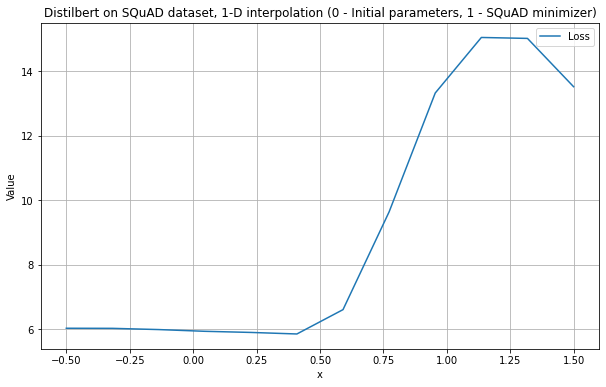

In [ ]:
import matplotlib.pyplot as plt

y_f1 = [y[i]['HasAns_f1' + '_1D_ip_' + str(i)] for i in range(0,12)]

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(x, od_loss_n, label = 'Loss')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Distilbert on SQuAD dataset, 1-D interpolation (0 - Initial parameters, 1 - SQuAD minimizer)')
plt.grid()
plt.legend()

plt.show()

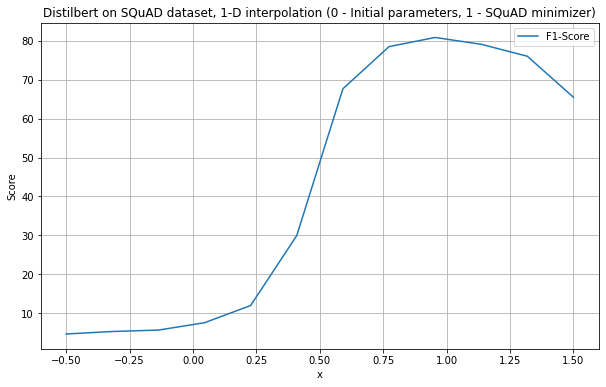

In [ ]:


plt.rcParams["figure.figsize"] = (10,6)
plt.plot(x, y_f1, label = 'F1-Score')
plt.xlabel('x')
plt.ylabel('Score')
plt.title('Distilbert on SQuAD dataset, 1-D interpolation (0 - Initial parameters, 1 - SQuAD minimizer)')
plt.grid()
plt.legend()

plt.show()

In [ ]:
import numpy as np
y_arr = [list(item.values()) for item in y]
new_array = np.array(od_loss_n)
print(new_array)

np.savetxt("./drive/My Drive/od_loss_n.txt", new_array, delimiter =", ")

[6.19301   6.2086353 6.1870127 6.103985  5.9495234 5.724959  5.4049134
 4.885947  4.013886  2.8736115 1.8461531 1.4201348 1.4521064 1.7094201
 2.146965  2.7955532 3.6567924 4.7454033]


## 2D interpolation

In [ ]:
def run_2D_interpolation(args, model_path_0, model_path_1, model_path_2, tokenizer_path,
                         n, alpha_range_x, alpha_range_y):

  model_0 = AutoModelForQuestionAnswering.from_pretrained(model_path_0) 
  model_1 = AutoModelForQuestionAnswering.from_pretrained(model_path_1) 
  model_2 = AutoModelForQuestionAnswering.from_pretrained(model_path_2) 
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

  #caching d/e/f, will skip if already done
  dataset, examples, features = load_and_cache_examples(args, tokenizer, evaluate=True, output_examples=True)
  dataset_t, examples_t, features_t = load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=True)

  start_pos = [x.start_position for x in features_t]
  end_pos = [x.end_position for x in features_t]

  dataset_mod = TensorDataset()
  dataset_mod.tensors = tuple([dataset.tensors[0],
                              dataset.tensors[1],
                              dataset.tensors[2],
                              dataset.tensors[3],
                              dataset.tensors[4],
                              dataset.tensors[5],
                              start_pos, 
                              end_pos])

  sd_0 = model_0.state_dict()
  sd_1 = model_1.state_dict()
  sd_2 = model_2.state_dict()

  delta_1 = state_dict_diff(sd_0, sd_1)
  delta_2 = state_dict_diff(sd_0, sd_2)
  z = []
  loss = []

  x = [alpha_range_x[0] + (alpha_range_x[1] - alpha_range_x[0]) * i / (n - 1.0) for i in range(0, n)]
  y = [alpha_range_y[0] + (alpha_range_y[1] - alpha_range_y[0]) * i / (n - 1.0) for i in range(0, n)]

  sqlen_1 = sum([torch.sum(torch.square(t)) for t in delta_1.values()])
  sqlen_2 = sum([torch.sum(torch.square(t)) for t in delta_2.values()])
  delta_2_scaled = state_dict_mult_n(delta_2, np.sqrt(sqlen_1/sqlen_2))

  for i in tqdm(range(0, n)):
    z_results = []
    loss_row = []

    for j in tqdm(range(0, n)):
      logger.info("Calculating node: {} / {}".format(i * n + j, n * n - 1))
      global_step = "1D_ip_" + str(i) + "_" + str(j)

      sd_n = state_dict_sum_coef(
          state_dict_sum_coef(sd_0, delta_1, x[i]),
          delta_2_scaled, y[j])

      model_n = AutoModelForQuestionAnswering.from_pretrained(model_path_0, state_dict = sd_n)
      model_n.to(args.device)

      # Evaluate
      result, loss_n = evaluate_for_batch(args, dataset_mod, examples, features, model_n, tokenizer, prefix=global_step)
      result = dict((k + ("_{}".format(global_step) if global_step else ""), v) for k, v in result.items())

      z_results.append(result)
      loss_row.append(loss_n)
    z.append(z_results)
    loss.append(loss_row)

  return x, y, z, loss

## Run 2D interpolation

In [ ]:
model_path_0 = "./drive/My Drive/distilbert-init/checkpoint-init"
model_path_1 = "./drive/My Drive/distilbert-squad-100/checkpoint-48000"
model_path_2 = "./drive/My Drive/distilbert-aqa-100/checkpoint-16000"
tokenizer_path = "./drive/My Drive/distilbert-squad-100/checkpoint-48000"

x_2, y_2, z, loss2d = run_2D_interpolation(args,
                               model_path_0, model_path_1, model_path_2, tokenizer_path,
                               n=10, alpha_range_x = [-1, 2], alpha_range_y = [-1, 2])

Выходные данные были обрезаны до нескольких последних строк (5000).

Evaluating:   0%|          | 0/1878 [00:00<?, ?it/s]

Evaluating:   0%|          | 9/1878 [00:00<00:21, 88.60it/s]

Evaluating:   1%|          | 18/1878 [00:00<00:21, 87.21it/s]

Evaluating:   1%|▏         | 27/1878 [00:00<00:21, 87.67it/s]

Evaluating:   2%|▏         | 36/1878 [00:00<00:20, 88.42it/s]

Evaluating:   2%|▏         | 45/1878 [00:00<00:21, 87.12it/s]

Evaluating:   3%|▎         | 55/1878 [00:00<00:20, 88.44it/s]

Evaluating:   3%|▎         | 65/1878 [00:00<00:20, 89.38it/s]

Evaluating:   4%|▍         | 75/1878 [00:00<00:20, 89.99it/s]

Evaluating:   4%|▍         | 84/1878 [00:00<00:19, 89.86it/s]

Evaluating:   5%|▌         | 94/1878 [00:01<00:19, 90.69it/s]

Evaluating:   6%|▌         | 104/1878 [00:01<00:19, 90.48it/s]

Evaluating:   6%|▌         | 114/1878 [00:01<00:19, 90.53it/s]

Evaluating:   7%|▋         | 124/1878 [00:01<00:19, 90.37it/s]

Evaluating:   7%|▋         | 134/1878 [00:01<00:19, 90.6

In [ ]:
len(loss2d)

10

In [ ]:
res = np.zeros([10,10])

for i in range(10):
  for j in range(10):
    res[i,j] = np.mean(od_loss[i][j])

In [ ]:
import numpy as np

new_array = np.array(res)
print(new_array)

np.savetxt("./drive/My Drive/z_loss_data_10.txt", new_array, delimiter =", ")


[[ 6.02065182  6.01465178  6.00705814  6.0109911   6.0198617   6.0240078
   6.0290041   6.02971077  6.02290344  6.02175903]
 [ 6.02929783  6.02452755  6.01917171  6.01671028  6.02765846  6.02737331
   6.03190804  6.03328943  6.02817154  6.02610826]
 [ 6.02179432  6.01634216  6.01873779  6.00695419  6.01980734  5.99949837
   6.00186729  6.0050168   6.00908375  6.00739336]
 [ 5.99684429  5.98932648  6.00328541  5.98352861  5.9937501   5.94423723
   5.93618298  5.9422493   5.96142483  5.96106625]
 [ 5.97254324  5.97541332  5.97782898  5.97525311  5.96994925  5.86703491
   5.83994484  5.83771038  5.87123299  5.87091541]
 [ 5.96772957  5.99280453  5.96423864  6.03628826  5.96054745  5.83194733
   5.71746254  5.72766495  5.75589848  5.76185989]
 [ 6.57195282  6.63691521  6.94297457  6.74441385  6.46989822  6.81667233
   6.56754112  6.45327044  6.3690424   6.44169426]
 [ 9.43591022 10.38887024 11.95717621 10.33774948  8.53238106  9.50449181
   9.47304344  9.54176998  7.96460533  7.94007111]
 

In [ ]:
def interpolate_list(arr, size):
  res = np.zeros((2 * size - 1))
  for i in range(0, size):
    res[2 * i] = arr[i]
  
  for i in range(1, 2 * size - 1, 2):
    res[i] = (res[i-1] + res[i + 1]) / 2

  return res

In [ ]:
def interpolate_array(arr, size):
  res = np.zeros((2 * size - 1, 2 * size - 1))
  for i in range(0, size):
    for j in range(0, size):
      res[2 * i, 2 * j] = arr[i,j]
  
  for i in range(1, 2 * size - 1, 2):
    for j in range(0, size):
      res[i, 2 * j] = (res[i-1, 2 * j] + res[i + 1, 2 * j]) / 2

  for i in range(0, size):
    for j in range(1, 2 * size - 1, 2):
      res[2 * i, j] = (res[2 * i, j-1] + res[2 * i, j+1]) / 2

  for i in range(1, 2 * size - 1, 2):
    for j in range(1, 2 * size - 1, 2):
      res[i, j] = (res[i-1, j-1] +
                   res[i-1, j+1] + 
                   res[i+1, j-1] +
                   res[i+1, j+1] ) / 4
  
  return res

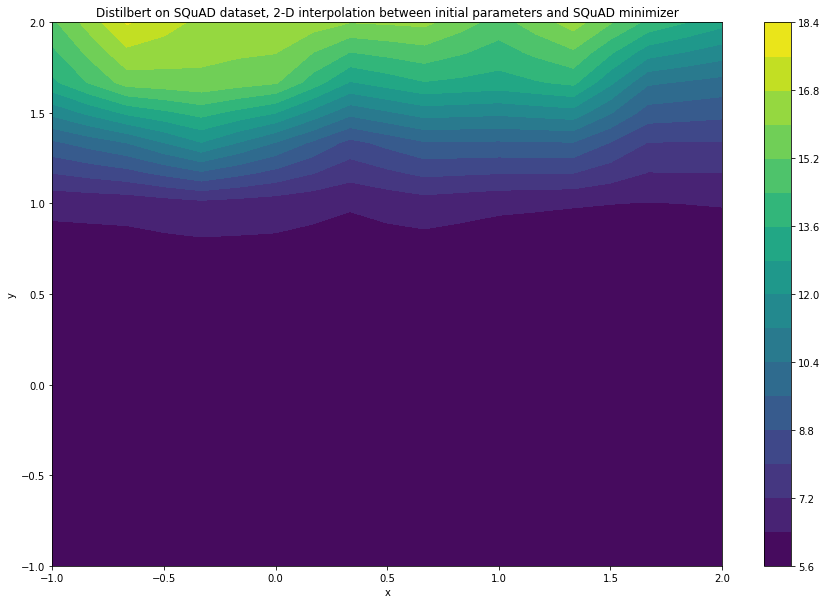

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
fig,ax=plt.subplots(1,1)
  

z_loss_np = interpolate_array(res, 10)
x_ip = interpolate_list(np.array(x_2), 10)
y_ip = interpolate_list(np.array(y_2), 10)

X, Y = np.meshgrid(x_ip, y_ip) 

cp = ax.contourf(X, Y, z_loss_np, levels = 15)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Distilbert on SQuAD dataset, 2-D interpolation between initial parameters and SQuAD minimizer')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [ ]:


plt.rcParams["figure.figsize"] = (10,6)
plt.plot(x, y_f1, label = 'F1-score')
plt.plot(x, loss, label = 'Loss')
plt.xlabel('x')
plt.ylabel('Score')
plt.title('Distilbert on SQuAD dataset, 1-D interpolation (0 - Initial parameters, 1 - SQuAD minimizer)')
plt.grid()
plt.legend()

plt.show()

In [ ]:
import pandas as pd
lista=pd.read_csv("./drive/My Drive/zdata_10.txt", sep=",", header=None)

In [ ]:
lista

,0,1,2,3,4,5,6,7,8,9
0,0.118906,6.769597,841.0,0.118906,6.769597,841.0,0.118906,0.0,6.769597,0.0
1,0.000000,7.070273,841.0,0.000000,7.070273,841.0,0.000000,0.0,7.070273,0.0
2,0.000000,5.972984,841.0,0.000000,5.972984,841.0,0.000000,0.0,5.972984,0.0
3,0.000000,2.690641,841.0,0.000000,2.690641,841.0,0.000000,0.0,2.690641,0.0
4,0.000000,5.856881,841.0,0.000000,5.856881,841.0,0.000000,0.0,5.856881,0.0
...,...,...,...,...,...,...,...,...,...,...
95,0.475624,3.351154,841.0,0.475624,3.351154,841.0,0.475624,0.0,3.351154,0.0
96,0.475624,3.042215,841.0,0.475624,3.042215,841.0,0.475624,0.0,3.042215,0.0
97,0.594530,5.600832,841.0,0.594530,5.600832,841.0,0.594530,0.0,5.600832,0.0
98,0.356718,7.816707,841.0,0.356718,7.816707,841.0,0.356718,0.0,7.816707,0.0


In [ ]:
z = lista.iloc[:, 0].to_numpy()
z1 = np.split(z, 10)
z1

[array([0.11890606, 0.        , 0.        , 0.        , 0.        ,
        0.11890606, 2.14030916, 1.78359096, 0.83234245, 0.59453032]),
 array([0.11890606, 0.        , 0.        , 0.        , 0.        ,
        1.30796671, 9.15576694, 4.39952438, 0.59453032, 0.71343639]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.07015458,
        18.43043995, 19.85731272,  6.3020214 ,  2.25921522,  0.35671819]),
 array([ 0.        ,  0.        ,  0.        ,  0.47562426, 11.77170036,
        41.14149822, 27.11058264, 10.10701546,  2.02140309,  1.07015458]),
 array([ 0.        ,  0.        ,  0.47562426, 12.960761  , 54.69678954,
        49.8216409 , 30.32104637,  9.98810939,  2.37812128,  0.95124851]),
 array([ 0.        ,  2.85374554, 18.66825208, 62.42568371, 67.65755054,
        53.62663496, 29.13198573,  8.20451843,  1.90249703,  0.35671819]),
 array([ 4.6373365 , 27.94292509, 61.59334126, 70.51129608, 66.34958383,
        49.94054697, 20.09512485,  4.04280618,  0.83234245,

In [ ]:
z_loss = [] 
for i in range(0,10):
  z_loss.append(
      [100 - z1[i][j] for j in range(0,10) ])

##Trajectory projection

In [ ]:
def run_trajectory_projection(args, model_path_0, model_path_1, checkpoints_list):

  model_0 = AutoModelForQuestionAnswering.from_pretrained(model_path_0) 
  model_1 = AutoModelForQuestionAnswering.from_pretrained(model_path_1) 

  sd_0 = model_0.state_dict()
  sd_1 = model_1.state_dict()

  delta_1 = state_dict_diff(sd_0, sd_1)

  x = []
  y = []

  sqlen_1 = sum([torch.sum(torch.square(t)) for t in delta_1.values()])

  for i in tqdm(range(0, len(checkpoints_list))):

    model_n = AutoModelForQuestionAnswering.from_pretrained(checkpoints_list[i])
    sd_n = model_n.state_dict()
    delta_n = state_dict_diff(sd_0, sd_n)

    sqlen_n = sum([torch.sum(torch.square(t)) for t in delta_n.values()])

    v_cos = state_dict_mult_scalar(delta_n, delta_1) / np.sqrt(sqlen_n * sqlen_1)

    d_alpha = v_cos * np.sqrt(sqlen_n / sqlen_1)

    d_beta = np.sqrt(sqlen_n / sqlen_1 - d_alpha * d_alpha)

    x.append(d_alpha)
    y.append(d_beta)
    
  return x, y

In [ ]:
model_path_0 = "./drive/My Drive/distilbert-init/checkpoint-init"
model_path_1 = "./drive/My Drive/distilbert-squad-100/checkpoint-48000"
checkpoints_list = [
                    "./drive/My Drive/distilbert-squad-100/checkpoint-8000",
                    "./drive/My Drive/distilbert-squad-100/checkpoint-16000",
                    "./drive/My Drive/distilbert-squad-100/checkpoint-24000",
                    "./drive/My Drive/distilbert-squad-100/checkpoint-32000",
                    "./drive/My Drive/distilbert-squad-100/checkpoint-40000",
                    "./drive/My Drive/distilbert-squad-100/checkpoint-48000",
                    ]

x_cp, y_cp = run_trajectory_projection(args, model_path_0, model_path_1, checkpoints_list)

100%|██████████| 6/6 [00:31<00:00,  5.32s/it]


In [ ]:
x_cpa = [0] + [it.item() for it in x_cp]
y_cpa = [0] + [it.item() for it in y_cp]

In [ ]:
x_cpa

[0,
 0.4369814395904541,
 0.6985232830047607,
 0.8576564788818359,
 0.9463721513748169,
 0.989151120185852,
 0.9999998807907104]

In [ ]:
alpha_range_x = [-1, 2]
alpha_range_y = [-1, 2]
n = 10

x_ip = [alpha_range_x[0] + (alpha_range_x[1] - alpha_range_x[0]) * i / (n - 1.0) for i in range(0, n)]
y_ip = [alpha_range_y[0] + (alpha_range_y[1] - alpha_range_y[0]) * i / (n - 1.0) for i in range(0, n)]

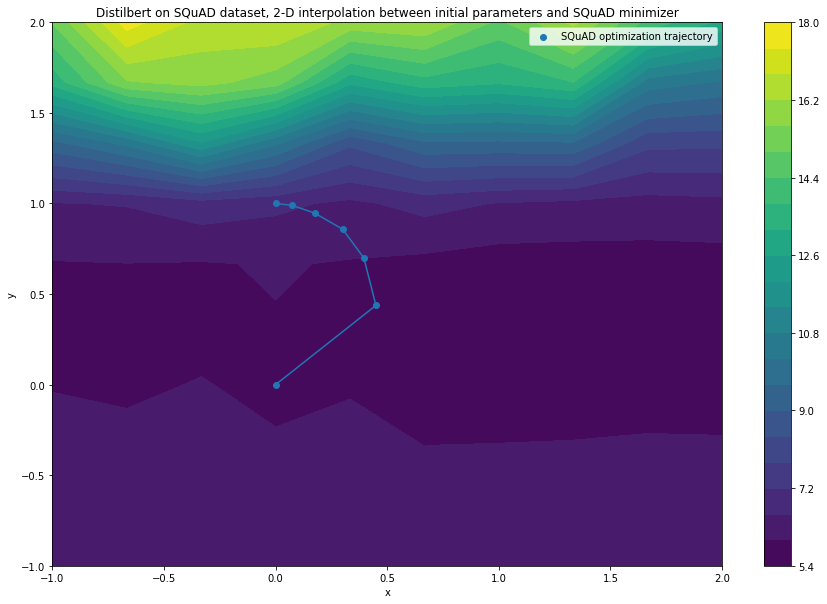

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
fig,ax=plt.subplots(1,1)

X, Y = np.meshgrid(x_ip, y_ip) 

cp = ax.contourf(X, Y, res, levels = 20)
fig.colorbar(cp) # Add a colorbar to a plot
plt.plot(y_cpa, x_cpa)
ax.scatter(y_cpa, x_cpa, label = 'SQuAD optimization trajectory')
ax.set_title('Distilbert on SQuAD dataset, 2-D interpolation between initial parameters and SQuAD minimizer')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()

plt.show()

# Perform Validation on Some Sample Contexts From Research Articles

In [ ]:
import torch

# To load different check points uncomment next two lines and use the checkpoint directory
model = AutoModelForQuestionAnswering.from_pretrained("./drive/My Drive/distilbert-aqa-100/aqa-clone")
tokenizer = AutoTokenizer.from_pretrained("./drive/My Drive/distilbert-aqa-100/aqa-clone")

contexts = ["My feet crunch on gravel as I finish up and slip into my home.  My neighbor’s cursing wakes me up in the morning."
            "I hear damn! and bollocks! I split the blinds with two fingers. The sun shines very bright and I squint to see my other neighbors file outside",

            "A mom’s job is never truly finished — Elise knew this instinctively when her son was born. For at least the hundredth time, she sat next"
            "to his bed in that chair mending his quilt. There was no way of knowing, the day she bought it at a flea market, that it would become her"
            "son’s most valued possession. To call it a quilt stretched the definition as it was nothing more than a thousand pieces of oddly shaped"
            "swatches stitched together, layer after layer, until the whole of it was thick enough to hold in the warmth.",

            "There are still rusted bayonets to be found in the dirt. Alongside broken firearms, canteens, and bullet-struck helmets. At times, still"
            "attached to skeletons. The deep-sea team would occasionally find a corroded tank or the remains of a submarine acting as an aquarium."
            "Fighter planes would turn up far off in the mountains, a surprise to climbers. Rare was it that Hisao found letters buried in Saipan."
            "He dropped his shovel and knelt, the archaeology team at work behind him—industrial lights illuminated the tunnel."
           ]

questions = [
    "What was the weather like?",
    "How many fragments it takes to make a quilt?",
    "What did planes do?",
]

for context, question in zip(contexts,questions):
    inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]
    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_start_scores, answer_end_scores = model(**inputs)
    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Answer: {answer}",end="\n\n")

Context: My feet crunch on gravel as I finish up and slip into my home.  My neighbor’s cursing wakes me up in the morning.I hear damn! and bollocks! I split the blinds with two fingers. The sun shines very bright and I squint to see my other neighbors file outside
Question: What was the weather like?
Answer: [UNK] sun shines very bright

Context: A mom’s job is never truly finished — Elise knew this instinctively when her son was born. For at least the hundredth time, she sat nextto his bed in that chair mending his quilt. There was no way of knowing, the day she bought it at a flea market, that it would become herson’s most valued possession. To call it a quilt stretched the definition as it was nothing more than a thousand pieces of oddly shapedswatches stitched together, layer after layer, until the whole of it was thick enough to hold in the warmth.
Question: How many fragments it takes to make a quilt?
Answer: a thousand

Context: There are still rusted bayonets to be found in the